<a href="https://colab.research.google.com/github/ZEBAAFROZ/Attention/blob/main/Visualizing_Attention_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U gdown -q

In [2]:
import zipfile
from io import BytesIO

import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [3]:
RESOLUTION = 224
PATCH_SIZE = 16
GITHUB_RELEASE = "https://github.com/sayakpaul/probing-vits/releases/download/v1.0.0/probing_vits.zip"
FNAME = "probing_vits.zip"
MODELS_ZIP = {
    "vit_dino_base16": "Probing_ViTs/vit_dino_base16.zip",
    "vit_b16_patch16_224": "Probing_ViTs/vit_b16_patch16_224.zip",
    "vit_b16_patch16_224-i1k_pretrained": "Probing_ViTs/vit_b16_patch16_224-i1k_pretrained.zip",
}

In [4]:
crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)


def preprocess_image(image, model_type, size=RESOLUTION):
    # Turn the image into a numpy array and add batch dim.
    image = np.array(image)
    image = tf.expand_dims(image, 0)

    # If model type is vit rescale the image to [-1, 1].
    if model_type == "original_vit":
        image = rescale_layer(image)

    # Resize the image using bicubic interpolation.
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")

    # Crop the image.
    image = crop_layer(image)

    # If model type is DeiT or DINO normalize the image.
    if model_type != "original_vit":
        image = norm_layer(image)

    return image.numpy()


def load_image_from_url(url, model_type):
    # Credit: Willi Gierke
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image

21675/21675 [==============================] - 0s 0us/step


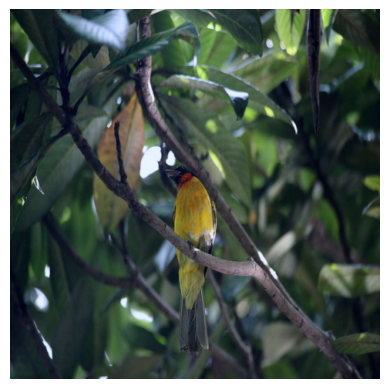

In [5]:
# ImageNet-1k label mapping file and load it.

mapping_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)

with open(mapping_file, "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image = load_image_from_url(img_url, model_type="original_vit")

plt.imshow(image)
plt.axis("off")
plt.show()

In [6]:
zip_path = tf.keras.utils.get_file(
    fname=FNAME,
    origin=GITHUB_RELEASE,
)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("./")

os.rename("Probing ViTs", "Probing_ViTs")


def load_model(model_path: str) -> tf.keras.Model:
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall("Probing_ViTs/")
    model_name = model_path.split(".")[0]

    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.models.load_model(model_name, compile=False)
    outputs, attention_weights = model(inputs, training=False)

    return keras.Model(inputs, outputs=[outputs, attention_weights])


vit_base_i21k_patch16_224 = load_model(MODELS_ZIP["vit_b16_patch16_224-i1k_pretrained"])
print("Model loaded.")

1346273766/1346273766 [==============================] - 10s 0us/step
Model loaded.


In [7]:
predictions, attention_score_dict = vit_base_i21k_patch16_224.predict(
    preprocessed_image
)
predicted_label = imagenet_int_to_str[int(np.argmax(predictions))]
print(predicted_label)

1/1 [==============================] - 9s 9s/step
toucan


### **Method I: Mean attention distance**

In [8]:
def compute_distance_matrix(patch_size, num_patches, length):
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:  # zero distance
                continue

            xi, yi = (int(i / length)), (i % length)
            xj, yj = (int(j / length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix


def compute_mean_attention_dist(patch_size, attention_weights, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # The attention_weights shape = (batch, num_heads, num_patches, num_patches)
    attention_weights = attention_weights[
        ..., num_cls_tokens:, num_cls_tokens:
    ]  # Removing the CLS token
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert length**2 == num_patches, "Num patches is not perfect square"

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token.
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(
        mean_distances, axis=-1
    )  # Sum along last axis to get average distance per token
    mean_distances = np.mean(
        mean_distances, axis=-1
    )  # Now average across all the tokens

    return mean_distances


In [14]:
# Build the mean distances for every Transformer block.
mean_distances = {
    f"{name}_mean_dist": compute_mean_attention_dist(
        patch_size=PATCH_SIZE,
        attention_weights=attention_weight,
        model_type="original_vit",
    )
    for name, attention_weight in attention_score_dict.items()
}

# Get the number of heads from the mean distance output.
num_heads = tf.shape(mean_distances["transformer_block_0_att_mean_dist"])[-1].numpy()

### **Method II: Attention Rollout**

In [9]:
def attention_rollout_map(image, attention_score_dict, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # Stack the individual attention matrices from individual Transformer blocks.
    attn_mat = tf.stack([attention_score_dict[k] for k in attention_score_dict.keys()])
    attn_mat = tf.squeeze(attn_mat, axis=1)

    # Average the attention weights across all heads.
    attn_mat = tf.reduce_mean(attn_mat, axis=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_attn = tf.eye(attn_mat.shape[1])
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / tf.reduce_sum(aug_attn_mat, axis=-1)[..., None]
    aug_attn_mat = aug_attn_mat.numpy()

    # Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")
    return result


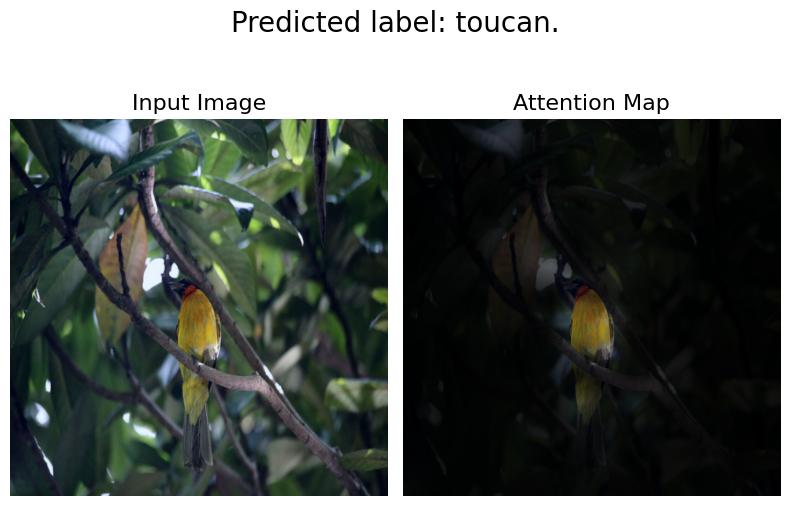

In [13]:
attn_rollout_result = attention_rollout_map(
    image, attention_score_dict, model_type="original_vit"
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 10))
fig.suptitle(f"Predicted label: {predicted_label}.", fontsize=20)

_ = ax1.imshow(image)
_ = ax2.imshow(attn_rollout_result)
ax1.set_title("Input Image", fontsize=16)
ax2.set_title("Attention Map", fontsize=16)
ax1.axis("off")
ax2.axis("off")

fig.tight_layout()
fig.subplots_adjust(top=1.35)
fig.show()

### **Method III: Attention heatmaps**

In [10]:
# Load the model.
vit_dino_base16 = load_model(MODELS_ZIP["vit_dino_base16"])
print("Model loaded.")

# Preprocess the same image but with normlization.
img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image = load_image_from_url(img_url, model_type="dino")

# Grab the predictions.
predictions, attention_score_dict = vit_dino_base16.predict(preprocessed_image)

Model loaded.
1/1 [==============================] - 1s 1s/step


In [11]:
def attention_heatmap(attention_score_dict, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1

    # Sort the Transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)

    # Process the attention maps for overlay.
    w_featmap = image.shape[2] // PATCH_SIZE
    h_featmap = image.shape[1] // PATCH_SIZE
    attention_scores = attention_score_dict[attention_score_list[0]]

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(
        attentions, size=(h_featmap * PATCH_SIZE, w_featmap * PATCH_SIZE)
    )
    return attentions


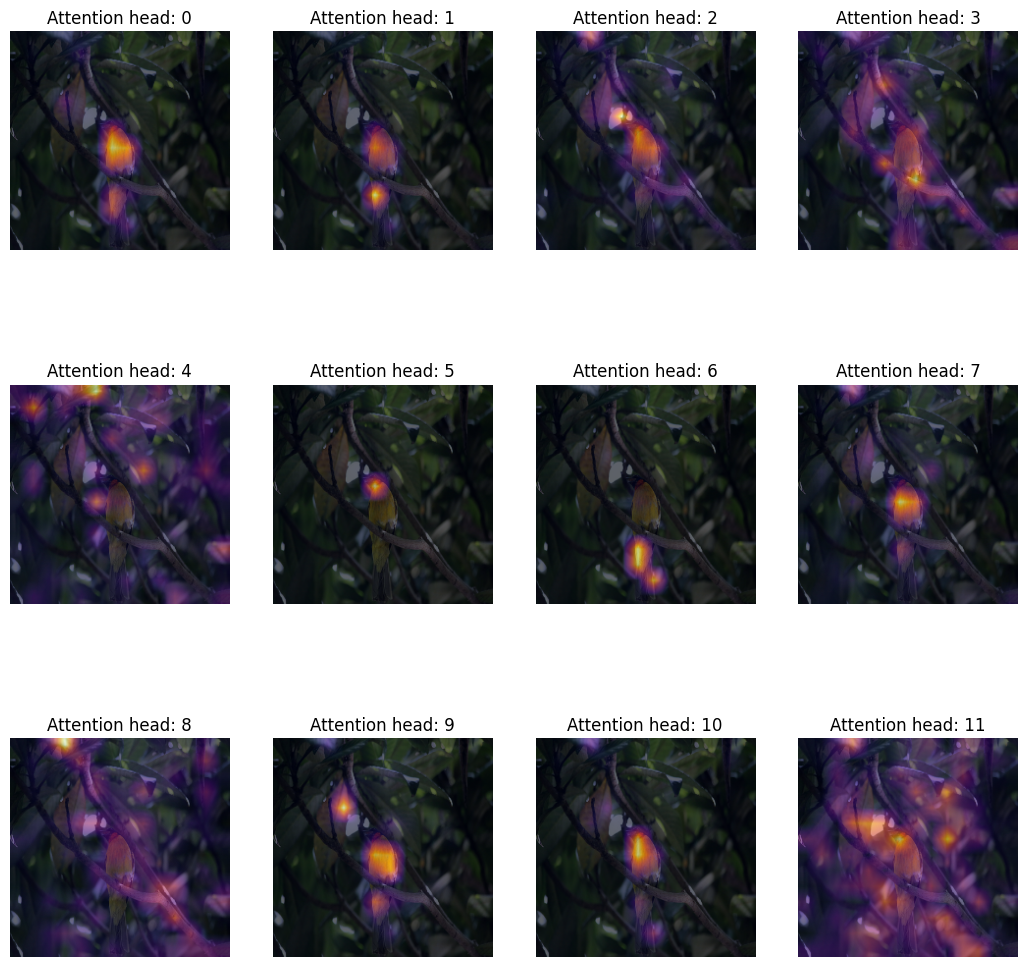

In [15]:
# De-normalize the image for visual clarity.
in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score_dict, preprocessed_img_orig)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0])
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1